In [4]:
import os
import sys
import pandas as pd
from pathlib import Path

# PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT"))
PROJECT_ROOT = Path("/home/Data_Analytics/traffic-incident-prediction")
SCRIPTS_DIR = PROJECT_ROOT / "scripts"
DATA_DIR = PROJECT_ROOT / "data"
IMG_DIR = PROJECT_ROOT / "img"
STAN_PATH = PROJECT_ROOT / "scripts/stan"
DATA_PATH = f"{PROJECT_ROOT}/data/analysis"

sys.path.append(str(PROJECT_ROOT))

In [5]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# data import
file_names = ['2021_mazowieckie.csv', 
              '2020_opolskie.csv',
              '2022_mazowieckie.csv']

data = []
for file_name in file_names:
    with open(f"{DATA_PATH}/{file_name}", 'r') as file:
        data.append(pd.read_csv(file))

## 3. Model

### Description
After thorough analization we decided to use a linear model and a Poisson model. 
Because of no previous knowlegde of this topic we had scarce understanding of what model we should choose. Based on the assumption that linear models are popular starting choice and they are effective when they works we set it as our first model. However first iterations were fairly different from this one.
$$ y \sim \text{Normal}(\mu, \sigma)$$
$$ \mu = \alpha + \beta \cdot h$$
$$ \alpha \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$$
$$ \beta \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$$

Second choosen model was a Poisson model because it is known for working well with data where certain number of events occur in a fixed interval - in this case it is number of accidents per month.
$$ y \sim \text{Poisson}(\lambda) $$
$$ \lambda = a \cdot h $$
$$ a \sim \text{Normal}(\mu_{a}, \sigma_{a})$$

## Priors



### Model 1 - prior predictive checks

Our priors have no phisical meaning of which one can be sure. However we can take some vague assumptions based on the data and other sources. We have chosen $\mu_{\alpha} = 4000$, because our data shows that this is a value simmilar to the mean number of accidents per voivodeship in last 20 years. To not be biased by data we picked fairly large $\sigma_{\alpha}$. $\mu_{\beta}$ and $\sigma_{\beta}$ were chosen to reasamble a weakly informative prior but with a wide range to better fit our expected data, which is in thousands magnitude. 

$$ \alpha \sim \text{Normal}(4000, 1500)$$
$$ \beta \sim \text{Normal}(0, 1000)$$

In [7]:
with open(f'{STAN_PATH}/prior1.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real temperature;
    array[N] real<lower=0> rainfall;
    array[N] real<lower=0, upper=100> humidity;
}

generated quantities {
    real alpha = normal_rng(4000, 1500);
    real beta = normal_rng(0, 1000);
    // real c = normal_rng(10, 1000);

    real<lower=0> sigma = exponential_rng(0.002);

    array[N] real<lower=0> accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = normal_rng(alpha + beta*humidity[i], sigma);
    }
}



// data {
//     int<lower=0> N;
//     // array[N] real avg_temp;
//     // array[N] real<lower=0> rainfall;
//     array[N] real<lower=0, upper=100> humidity;
// }

// generated quantities {
//     real a = normal_rng(0, 10);
//     // real b = normal_rng(0, 10);
//     real c = normal_rng(10, 10);

//     real<lower=0> sigma = exponential_rng(0.5);

//     array[N] real<lower=0> accidents_pred;
//     for (i in 1:N) {
//         accidents_pred[i] = normal_rng(a + c*humidity[i], sigma);
//     }
// }


// da

In [8]:
model1_ppc = CmdStanModel(stan_file=f'{STAN_PATH}/prior1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [9]:
def data_sim(df):
    return {'N': len(df), 
            'temperature': df['temperature'],
            'rainfall': df['rainfall'],
            'humidity': df['humidity']}

R = 1000
sim = model1_ppc.sample(
    data=data_sim(data[1]),
    iter_sampling=R,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=42,
    refresh=R
)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)
alpha_pred = sim.stan_variable("alpha")
beta_pred = sim.stan_variable("beta")
sigma_pred = sim.stan_variable("sigma")

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


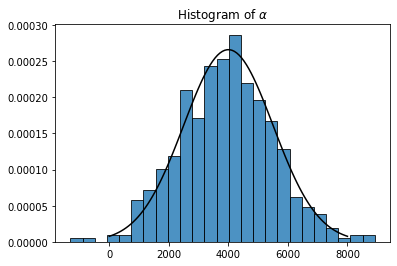

In [10]:
x = np.linspace(-0, 8000, 100)
y = stats.norm.pdf(x=x, loc=4000, scale=1500)
plt.hist(alpha_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of $\alpha$')
plt.show()

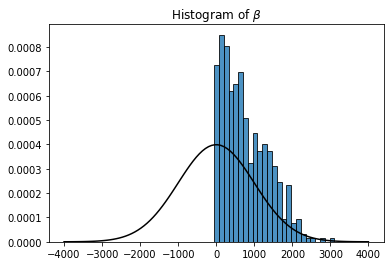

In [11]:
x = np.linspace(-4000, 4000, 100)
y = stats.norm.pdf(x=x, loc=0, scale=1000)
plt.hist(beta_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of $\beta$')
plt.show()

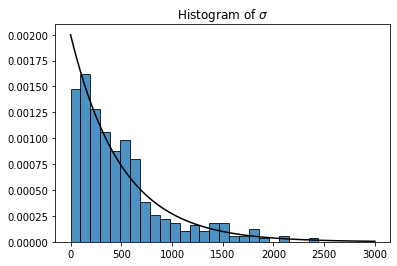

In [12]:
x = np.linspace(0, 3000, 100)
y = stats.expon.pdf(x=x, scale=500)
plt.hist(sigma_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of $\sigma$')
plt.show()


### Model 2 - prior predictive checks

In [13]:
with open(f"{DATA_DIR}/intermediate/data_all.csv") as f:
    d = pd.read_csv(f)

In [14]:
tuning = CmdStanModel(stan_file=f'{STAN_PATH}/prior_tune.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [15]:
# a upper bound calculation
mean_humidity = np.mean(d['humidity'])
root_of_lambda = np.polynomial.polynomial.polyroots([-15000., 3., 1.])
root_of_a = np.polynomial.polynomial.polyroots([-15000./mean_humidity, 3./np.sqrt(mean_humidity), 1.])
a_ub = root_of_a[root_of_lambda>0]**2
print(f'a upper bound: {a_ub[0]:.2f}')

a upper bound: 174.21


In [16]:
# sigma_a calculation
data_tune = dict(y_guess = np.array([np.log(100)]),
                 theta = np.array(a_ub))
tuned = tuning.sample(data=data_tune,
                      seed=1052020,
                      fixed_param=True,
                      iter_sampling=1, 
                      iter_warmup=1,
                      #   show_console=True,
                      chains=1)
sigma = tuned.stan_variable('sigma')[0]
print(f'Computed suggested standard deviation for parameter a: {sigma:.0f}')

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



Computed suggested standard deviation for parameter a: 68


The distribution of the parameter $a$ was selected through a series of steps. First, we determined the upper bound of $\lambda$. Historically, the highest number of accidents per month per voivodeship is approximately 7,000. To ensure we were not biased by searching for patterns in the data, we set the upper bound to be at least twice this highest recorded value, resulting in an upper bound of 15,000.

Next, we used a known equation for the upper bound based on $\lambda = a \cdot h_{\text{avg}}$, where $h_{\text{avg}}$ is the mean value of humidity in the dataset:

$$ a \cdot h_{\text{avg}} + 3 \sqrt{a \cdot h_{\text{avg}}} \approx 15{,}000 \implies a \cdot h_{\text{avg}} = 14{,}637 $$

This relationship was then utilized to tune the priors in the model, which returned the suggested value for $\sigma_{a}$:

$$a \sim \text{Normal}(0, 68) $$

In [17]:
with open(f'{STAN_PATH}/prior2.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    // array[N] real temperature;
    // array[N] real<lower=0> rainfall;
    array[N] real<lower=0, upper=100> humidity;
}

generated quantities {
    real a = abs(normal_rng(0, 67));    // 82
    // real b = normal_rng(0, 10);
    // real c = normal_rng(10, 10);

    // real<lower=0> sigma = exponential_rng(0.5);

    array[N] int<lower=0> accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = poisson_rng(a*humidity[i]);
    }
}




In [18]:
model2_ppc = CmdStanModel(stan_file=f'{STAN_PATH}/prior2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [19]:
def data_sim(df):
    return {'N': len(df), 
            'temperature': df['temperature'],
            'rainfall': df['rainfall'],
            'humidity': df['humidity']}

R = 1000
sim = model2_ppc.sample(
    data=data_sim(data[1]),
    iter_sampling=R,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=42,
    refresh=R
)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)
a_pred = sim.stan_variable("a")
# beta_pred = sim.stan_variable("beta")
# sigma_pred = sim.stan_variable("sigma")

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


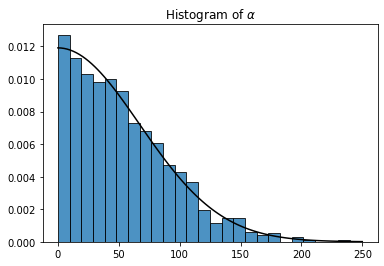

In [20]:
x = np.linspace(0, 250, 100)
y = 2 * stats.norm.pdf(x=x, loc=0, scale=67)
plt.hist(a_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of $\alpha$')
plt.show()

## Posterior analysis (model 1)

In [21]:
with open(f'{STAN_PATH}/fit1.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real temperature;
    // array[N] real<lower=0> rainfall;
    array[N] real<lower=0, upper=100> humidity;
    array[N] real<lower=0> accidents;
}

parameters {
    real alpha;
    real beta;
    // real c;
    real<lower=0> sigma;
}

transformed parameters {
    vector[N] mu;
    for (i in 1:N) {
        mu[i] = humidity[i]*beta + alpha;
    }
}

model {
    alpha ~ normal(4000, 1500);
    beta ~ normal(0, 1000);
    // c ~ normal(0, 2000);
    sigma ~ exponential(0.002);

    accidents ~ normal(mu, sigma);
    // for (i in 1:N) {
    //     accidents ~ normal(a*temperature[i] + c*humidity[i], sigma);
    // }
}

generated quantities {
    array[N] real accidents_pred;
    array[N] real log_lik;
    for (i in 1:N) {
        log_lik[i] = normal_lpdf(accidents[i] | mu[i], sigma);
        accidents_pred[i] = normal_rng(mu[i], sigma);
    }
}



// data {
//     int<lower=0> N;
//     array[N] real temperature;
//     // array[N] real<lower=0> rainfa

In [22]:
model_1_fit = CmdStanModel(stan_file=f'{STAN_PATH}/fit1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [23]:
def fit_model1(df): 

    data_sim = {
        'N': len(df), 
        'temperature': df['temperature'],
        # 'rainfall': df['rainfall'],
        'humidity': df['humidity'],
        'population_density': df['population_density'],
        # 'vehicles': df['vehicles'],
        'accidents': df['incidents']}

    fit = model_1_fit.sample(data=data_sim,
                            output_dir='samples', 
                            show_progress=False,
                            seed=28052020)

    # a_fit = fit.stan_variable('a')
    # b_fit = fit.stan_variable('b')
    # c_fit = fit.stan_variable('c')
    accidents_pred = fit.stan_variable('accidents_pred')

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.bar(list(df['month']), df['incidents'].values, alpha=0.5)
    ax1.bar(list(df['month']), np.mean(accidents_pred, axis=0), alpha=0.5)
    # ax2.invert_yaxis()
    # ax2.set_yticks(np.arange(1, 21))
    # ax2.set_yticklabels([i+1 for i in range(20)])
    # ax2.scatter(list(d_new['driver_name']), d_new.race_position, color='r')
    plt.show()

    return fit

In [24]:
def data_sim(df):
    return {
    'N': len(df), 
    'temperature': df['temperature'],
    # 'rainfall': df['rainfall'],
    'humidity': df['humidity'],
    'population_density': df['population_density'],
    # 'vehicles': df['vehicles'],
    'accidents': df['incidents']}

sim = model_1_fit.sample(data=data_sim(data[0]),
                        output_dir='samples', 
                        show_progress=False,
                        seed=28052020)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)
alpha_pred = sim.stan_variable("alpha")
beta_pred = sim.stan_variable("beta")
sigma_pred = sim.stan_variable("sigma")

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing


INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing


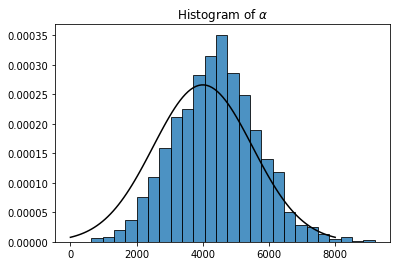

In [25]:
x = np.linspace(-0, 8000, 100)
y = stats.norm.pdf(x=x, loc=4000, scale=1500)
plt.hist(alpha_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of $\alpha$')
plt.show()

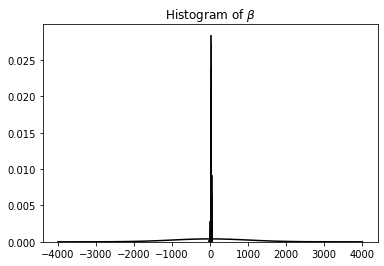

In [26]:
x = np.linspace(-4000, 4000, 100)
y = stats.norm.pdf(x=x, loc=0, scale=1000)
plt.hist(beta_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of $\beta$')
plt.show()

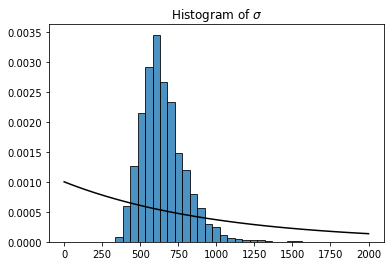

In [27]:
x = np.linspace(0, 2000, 100)
y = stats.expon.pdf(x=x, scale=1000)
plt.hist(sigma_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of $\sigma$')
plt.show()

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing


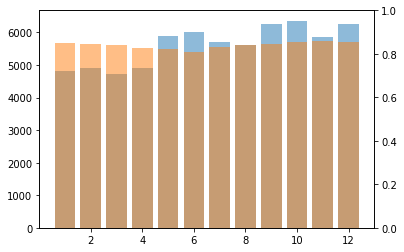

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


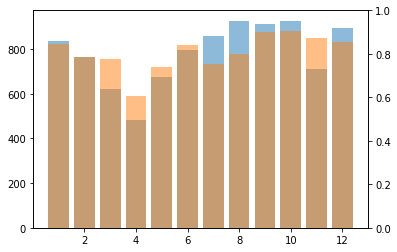

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing


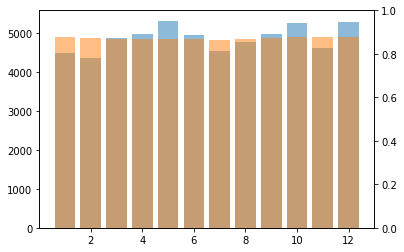

In [28]:
samples1_0 = fit_model1(data[0])
samples1_1 = fit_model1(data[1])
samples1_2 = fit_model1(data[2])

## Posterior analysis (model 2)

We’re estimating number of road accidents per county per month based on weather conditions and available social data.
Historically the highest number of accidents per month per county any is about equal 7000. Based on that we can assume the value of the upper bound of the number of accidents per month per county. To not be biased by searching for patterns in simulating data we’ll set the upper bound to be at least 2 times as big as the highest recorded data. So at the end the upper bound will be set to 15_000.
Based on Poisson() distribution it gives:
λ+3√λ≈15000 ⇒ λ=14637


In [29]:
with open(f'{STAN_PATH}/fit2.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real<lower=0, upper=100> humidity;
    // array[N] real<lower=-30, upper=50> avg_temp;
    array[N] int<lower=0> accidents;
}

parameters {
    real<lower=0> a;
    // real b;
}

model {
    a ~ normal(0, 67);
    // b ~ normal(0, 40);
    for (i in 1:N) {
        accidents[i] ~ poisson(a*humidity[i]);
    }
}

generated quantities {
    array[N] int accidents_pred;
    array[N] real log_lik;
    for (i in 1:N) {
        log_lik[i] = poisson_lpmf(accidents[i] | a*humidity[i]);
        accidents_pred[i] = poisson_rng(a*humidity[i]);
    }
}


In [30]:
model_2_fit = CmdStanModel(stan_file=f'{STAN_PATH}/fit2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [31]:
def fit_model2(df): 

    data_sim = {
        'N': len(df), 
        'avg_temp': df['temperature'],
        # 'rainfall': df['rainfall'],
        'humidity': df['humidity'],
        'accidents': df['incidents']}

    fit = model_2_fit.sample(data=data_sim,
                            output_dir='samples', 
                            show_progress=False,
                            seed=28052020)

    a_fit = fit.stan_variable('a')
    # b_fit = fit.stan_variable('b')
    # c_fit = fit.stan_variable('c')
    accidents_pred = fit.stan_variable('accidents_pred')

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.bar(list(df['month']), df['incidents'].values, alpha=0.5)
    ax1.bar(list(df['month']), np.mean(accidents_pred, axis=0), alpha=0.5)
    # ax2.invert_yaxis()
    # ax2.set_yticks(np.arange(1, 21))
    # ax2.set_yticklabels([i+1 for i in range(20)])
    # ax2.scatter(list(d_new['driver_name']), d_new.race_position, color='r')
    plt.show()
    return fit

In [32]:
def data_sim(df):
    return {
    'N': len(df), 
    'temperature': df['temperature'],
    # 'rainfall': df['rainfall'],
    'humidity': df['humidity'],
    'population_density': df['population_density'],
    # 'vehicles': df['vehicles'],
    'accidents': df['incidents']}

sim = model_2_fit.sample(data=data_sim(data[0]),
                        output_dir='samples', 
                        show_progress=False,
                        seed=28052020)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)
a_pred = sim.stan_variable("a")

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


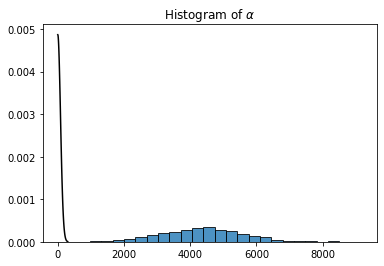

In [33]:
x = np.linspace(-0, 300, 100)
y = stats.norm.pdf(x=x, loc=0, scale=82)
plt.hist(alpha_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of $\alpha$')
plt.show()

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing


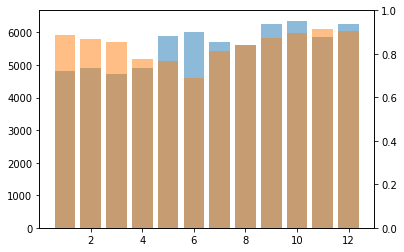

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing


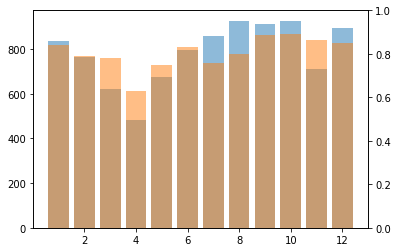

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing


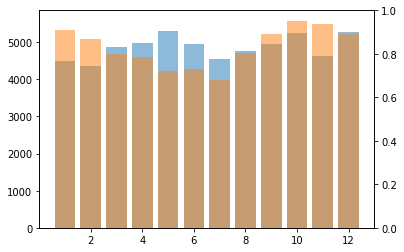

In [34]:
samples2_0 = fit_model2(data[0])
samples2_1 = fit_model2(data[1])
samples2_2 = fit_model2(data[2])

## Model comparison

In [35]:
# model1_data = az.from_cmdstanpy(posterior=samples1_0,
#                                 log_likelihood='log_lik',
#                                 posterior_predictive='y_hat')

# model2_data = az.from_cmdstanpy(posterior=samples2_0,
#                                 log_likelihood='log_lik',
#                                 posterior_predictive='y_hat')

In [36]:
comp_dict = {"model 1": samples1_0,
             "model 2": samples2_0}


### WAIC criterion

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


         rank         waic     p_waic       d_waic  weight          se  \
model 1     0   191.234867   1.598767     0.000000     1.0    2.661224   
model 2     1  1378.927715  89.823352  1187.692848     0.0  438.388220   

                dse  warning waic_scale  
model 1    0.000000    False   deviance  
model 2  436.856386     True   deviance  


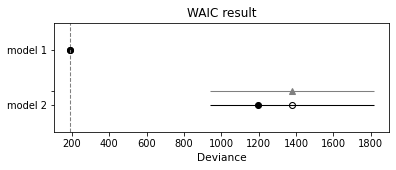

In [37]:
comp_waic = az.compare(comp_dict, ic="waic", scale='deviance')
print(comp_waic)
az.plot_compare(comp_waic)
plt.title('WAIC result')
plt.show()

### PSIS-LOO criterion

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


         rank         loo      p_loo       d_loo  weight          se  \
model 1     0  -95.678059   1.659392    0.000000     1.0    1.345074   
model 2     1 -679.393675  79.753169  583.715616     0.0  213.949351   

                dse  warning loo_scale  
model 1    0.000000    False       log  
model 2  213.153664     True       log  


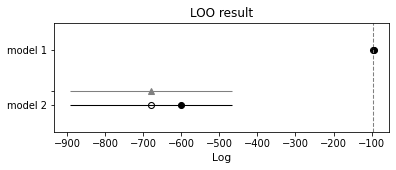

In [38]:
comp_loo = az.compare(comp_dict, ic="loo")
print(comp_loo)
az.plot_compare(comp_loo)
plt.title('LOO result')
plt.show()